In [1]:
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_master=pd.read_csv('E:\data\PPD_Training_Master_GBK_3_1_Training_Set.csv',encoding='gb18030') #这里是gbk编码，encode需要进行处理
data_log=pd.read_csv('E:\data\PPDlog.csv',encoding='gb18030')
data_update=pd.read_csv('E:\data\PPDupdate.csv',encoding='gb18030')
# data=pd.concat([data_master,data_log,data_updata],axis=1)

In [3]:
#将'不详' 转为空值,将Idx转为字符类型
data_master=data_master.replace('不详',np.nan)
data_master['Idx']=data_master['Idx'].apply(str)
data_log['Idx']=data_log['Idx'].apply(str)
data_update['Idx']=data_update['Idx'].apply(str)

In [4]:
#观察缺失值情况，并进行细化处理
na_percent=(data_master.isnull().sum()/data_master.isnull().count()).sort_values(ascending=False)
nap=na_percent.to_frame()


In [5]:
#空值率高于0.9的字段直接删除
nap=na_percent.to_frame()
data_master=data_master[nap[nap<0.9].dropna().index.tolist()]  #将包含这些列名的列扔掉，注意对测试集做相同处理

In [6]:
#这里我们不像之前的空值简单的用众数或者中位数填充，对user_info11这样的字段，我们将空值用-1填充，因为未填充也可以看做某种特征
data_master['UserInfo_11'].fillna(-1,inplace=True)
data_master['UserInfo_12'].fillna(-1,inplace=True)
data_master['UserInfo_12'].fillna(-1,inplace=True)

In [7]:
#对于剩余的空值，用众数填充


In [8]:
#另外有一些字段的特征需要进行其他的预处理
#将字母全部转为小写，空格全部删除，带省市的后缀全部删除
def to_lower(s):
    return s.lower()
#删除空格
def del_sp(s):
    import re
    a=re.sub('\s','',s)
    return a

#删除省市
def del_s(s):
    import re
    a=s.replace('市','')
    b=a.replace('省','')
    return b

#判断中文
def is_c(uchar):
        if uchar >= u'\u4e00' and uchar<=u'\u9fa5':
                return True
        else:
                return False
            
#进行处理，分为中文和英文
clstr=data_master.select_dtypes(include=['object']).columns.tolist()
clz=[]
clw=[]
for c in clstr:
    if is_c(data_master.loc[0,c]):
        clz.append(c)
    else:
        clw.append(c)

data_master[clz]=data_master[clz].applymap(del_sp)
data_master[clz]=data_master[clz].applymap(del_s)

data_master[clw]=data_master[clw].applymap(del_sp)
data_master[clw]=data_master[clw].applymap(to_lower)

In [9]:
#对update数据集进行统一小写处理
#当只有一列时为series，此时用apply而不是applymap
clw='UserupdateInfo1'
data_update[clw]=data_update[clw].apply(del_sp)
data_update[clw]=data_update[clw].apply(to_lower)

In [10]:
#由于这个数据集的特征主要以类别为主，且很多类别特征列的类型是数字，因此有必要将其转为字符字段后进行独热编码。
#但在此之前对于城市字段应将其进行空间上的聚类，利用经纬度，并将其返回到一个6-10的向量中储存

In [11]:
cityr_dr='E:\data\city_ranking.txt'
#l用来存储6个城市分级
l=6*[1]
for i in range(6):
    l[i]=[]
    
with open(cityr_dr,'r') as f:
    i=0   
    for line in f.readlines():        
        if line.find('线城市')==-1:
            a=line.strip('\n')
            #这里用条件语句是为了避免直辖市
            if a.find('：')==-1:
                b=a
            else:
                a=a.split('：')
                b=a[1]
                
            c=del_s(b)
            l[i].append(c)
        else:            #当发现城市评级标志，转到下一个城市分级列表进行存储
            i=i+1



In [12]:
#将城市标签转为分级标签进行存储
def to_rank(s):
    for i in range(6):
        if s in l[i]:
            a=i
            break
        elif i==5:
            a=i
    return a

#包含城市字段的列表lc
lc=['UserInfo_2','UserInfo_4','UserInfo_8','UserInfo_20']
lp=['UserInfo_7','UserInfo_19']

data_master[lc]=data_master[lc].applymap(to_rank)

In [13]:
#一些字段（如详细地址）可能包含很多非重复情况，但对实际并没有用，我们将类型为字符串的字段提出来，
#观察两个方面，非重复的计数以及计数最多元素的数量，如果前者多且后者少，直接删除字段，如果前者多而后者多，将该元素和其他元素做二元编码
count_max=pd.DataFrame(index={'c','m'})

dm_str=data_master.select_dtypes(include='object')

for c in dm_str.columns.tolist():
    count_max.loc['c',c]=len(dm_str[c].unique())
    count_max.loc['m',c]=dm_str.groupby(c).count().apply(max).max()
count_max.sort_values(by='m',axis=1)

,Idx,ListingInfo,UserInfo_19,UserInfo_7,WeblogInfo_20,UserInfo_9,WeblogInfo_21,WeblogInfo_19,UserInfo_24,UserInfo_23,Education_Info2,Education_Info3,Education_Info4,UserInfo_22,Education_Info6,Education_Info8,Education_Info7
m,1.0,431.0,2405.0,8094.0,19192.0,21455.0,24752.0,24940.0,27868.0,28003.0,28110.0,28110.0,28110.0,28163.0,29026.0,29143.0,30000.0
c,30000.0,338.0,31.0,31.0,36.0,3.0,4.0,7.0,1962.0,26.0,7.0,3.0,6.0,6.0,6.0,6.0,1.0


In [14]:
#根据上表进行操作
data_master.drop('Education_Info7',inplace=True,axis=1)

#针对us24专门进行处理的函数
def f(x):
    if x!='d':
        x='nd'
    return x

data_master['UserInfo_24']=data_master['UserInfo_24'].apply(f)

In [15]:
#一些字段虽然是数字类型，但数量稀少考虑将其进行独热编码
u_count=pd.DataFrame(index=[0])

for c in data_master.columns.tolist():
    u_count.loc[0,c]=len(data_master[c].unique())
u_sort=u_count.sort_values(by=0,axis=1)

In [16]:
u_sort.iloc[:,90:120]

,UserInfo_19,UserInfo_7,WeblogInfo_5,ThirdParty_Info_Period7_9,WeblogInfo_20,UserInfo_18,WeblogInfo_9,WeblogInfo_8,WeblogInfo_15,WeblogInfo_6,...,ThirdParty_Info_Period3_9,ThirdParty_Info_Period1_9,ThirdParty_Info_Period6_12,ThirdParty_Info_Period7_6,WeblogInfo_17,ThirdParty_Info_Period2_9,ThirdParty_Info_Period5_12,ThirdParty_Info_Period1_11,ThirdParty_Info_Period1_12,ThirdParty_Info_Period6_11
0,31.0,31.0,34.0,35.0,36.0,39.0,39.0,48.0,51.0,58.0,...,92.0,93.0,97.0,102.0,104.0,104.0,111.0,112.0,121.0,124.0


In [17]:
#通过观察以上表格，<=102的字段作独热处理，之后的仍视为数值进行处理
#需要转为字符类存储的字段
t=104
l_to_str=u_sort[u_sort<104].dropna(axis=1).columns.tolist()

In [18]:
data_master[l_to_str]=data_master[l_to_str].applymap(str)

In [19]:
#以上我们主要完成了：
#对空值进行填充和删除
#将城市字段调整为城市分级
#将更适合做类别特征的字段调整为字符串类型
#接下来将对log和update两部分数据进行处理

In [20]:
#具体处理包括：1将info字段类型转为字符串，并对其get_dummies后求和，算出每种操作的操作数量，操作的总数量
#2将日期字段全部转为日期类型，求出Listinfo的月份，Log3的时间间隔

In [21]:
#信息转字符,仅对log
data_log[['LogInfo1','LogInfo2']]=data_log[['LogInfo1','LogInfo2']].applymap(str)

In [22]:
#转日期类型,对log和update处理
data_log['Listinginfo1']=pd.to_datetime(data_log['Listinginfo1'])
data_log['LogInfo3']=pd.to_datetime(data_log['LogInfo3'])

data_update['ListingInfo1']=pd.to_datetime(data_update['ListingInfo1'])
data_update['UserupdateInfo2']=pd.to_datetime(data_update['UserupdateInfo2'])

In [23]:
#log字符串get_dummies并求和
dlog_info=pd.get_dummies(data_log[['LogInfo1','LogInfo2']])
dlog_info['Idx']=data_log['Idx'].tolist()
dlog_info_sum=dlog_info.groupby('Idx').sum()

In [24]:
dlog_info_sum.head()

,LogInfo1_-10,LogInfo1_-4,LogInfo1_0,LogInfo1_1,LogInfo1_10,LogInfo1_100,LogInfo1_1000,LogInfo1_101,LogInfo1_102,LogInfo1_103,...,LogInfo2_19,LogInfo2_2,LogInfo2_20,LogInfo2_21,LogInfo2_22,LogInfo2_23,LogInfo2_3,LogInfo2_4,LogInfo2_6,LogInfo2_7
Idx,,,,,,,,,,,,,,,,,,,,,
10001,0.0,7.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0
10002,0.0,14.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,1.0
10003,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0
10006,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10007,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0


In [25]:
#log接下来对日期进行处理
#1提取listinfo的月
def t2m(date):
    return date.month

data_log['month']=data_log['Listinginfo1'].apply(t2m)

dlog_date=data_log.drop(['Listinginfo1','LogInfo1','LogInfo2','LogInfo3'],axis=1).drop_duplicates()
dlog_date=dlog_date.set_index(['Idx'])  #groupby处理后的index均为Idx，这里为了之后统一按索引合并

In [26]:
#2提取loginfo3的时间间隔
def tdif(df):
    a=(df['LogInfo3'].max()-df['LogInfo3'].min()).days
    return a

dlog_dif=data_log.groupby('Idx').apply(tdif).to_frame()
dlog_dif.columns=['dif']


In [27]:
#统计总共的操作数量log
dlog_count=data_log.groupby('Idx')['month'].count().to_frame()
dlog_count.columns=['log_count']
dlog_count.columns

Index(['log_count'], dtype='object')

In [28]:
#log数据最终处理结果
datal=dlog_info_sum.join(dlog_date)
datal=datal.join(dlog_dif)
datal=datal.join(dlog_count)

In [29]:
#对update作相似处理
#1get_dummies并求和
dupdate_info=pd.get_dummies(data_update['UserupdateInfo1'])
dupdate_info['Idx']=data_update['Idx'].tolist()
dupdate_info_sum=dupdate_info.groupby('Idx').sum()

In [30]:
#update的info2-info1
def diflu(df):
    a=(df['ListingInfo1'].max()-df['UserupdateInfo2'].max()).days
    return a

dupdate_dif=data_update.groupby('Idx').apply(diflu).to_frame()
dupdate_dif.columns=['difu']

In [31]:
#统计总共的操作数量update
dupdate_count=data_update.groupby('Idx')['ListingInfo1'].count().to_frame()
dupdate_count.columns=['update_count']
dupdate_count.columns

Index(['update_count'], dtype='object')

In [32]:
#datau为update的处理结果
datau=dupdate_info_sum.join(dupdate_dif)
datau=datau.join(dupdate_count)

In [33]:
data_master=data_master.set_index(['Idx'])
data=data_master.join(datal)
data=data.join(datau)

In [34]:
data.fillna(0,inplace=True)

In [35]:
#由于log和update的部分字段必须先独热编码才能提取特征，

In [36]:
data['target']=data['target'].astype(int)
data_str=data.select_dtypes(include='object')
data_num=data.drop(data_str.columns,axis=1)
data_str=pd.get_dummies(data_str)

In [37]:
data0=data

In [38]:
data_target=data['target']
data_num=data_num.drop(['target'],axis=1)   #df是扔掉目标值的data
from sklearn import preprocessing
mms=preprocessing.MinMaxScaler()
data_num.iloc[:,:]=mms.fit_transform(data_num.values)  

#数据部分主要特征提取,lnum用于存储各个属性与目标变量的互信息
import sklearn.metrics 
from sklearn.metrics import normalized_mutual_info_score 
lnum=pd.DataFrame(index=['score'])                         #l为各个属性与目标变量的关联程度
for c in data_num.columns:
    lnum.loc['score',c]=normalized_mutual_info_score(data_num[c],data_target.values)
lnum_sort=lnum.sort_values(by='score',axis=1,ascending=False)
data_num=data_num[lnum[lnum>0.001].dropna(axis=1).columns.tolist()]

#字符部分主要特征提取
lstr=pd.DataFrame(index=['score'])
for c in data_str.columns:
    lstr.loc['score',c]=normalized_mutual_info_score(data_str[c],data_target.values)
lstr_sort=lstr.sort_values(by='score',axis=1,ascending=False)
data_str=data_str[lstr[(lstr>0.001) & (lstr<0.3)].dropna(axis=1).columns.tolist()]



#将两部分合并成为新的data
data=pd.concat([data_num,data_str],axis=1)
data_all=pd.concat([data,data_target],axis=1)

In [39]:
lnum_sort

,ThirdParty_Info_Period2_16,ThirdParty_Info_Period2_13,ThirdParty_Info_Period3_16,ThirdParty_Info_Period3_13,ThirdParty_Info_Period4_16,ThirdParty_Info_Period2_14,ThirdParty_Info_Period4_13,ThirdParty_Info_Period1_16,ThirdParty_Info_Period3_14,ThirdParty_Info_Period1_13,...,LogInfo1_302,_hassborgjj,LogInfo1_12,_flag_uctobcp,_gender,LogInfo2_0,_age,LogInfo1_305,LogInfo1_304,LogInfo1_303
score,0.134983,0.132903,0.132336,0.131722,0.129507,0.128613,0.127571,0.125655,0.125378,0.123035,...,0.000134,0.000129,0.000087,0.000062,0.000053,0.000017,0.000016,0.000007,0.000005,0.000004


In [40]:
lstr_sort

,WeblogInfo_15_26,ThirdParty_Info_Period7_2_59,WeblogInfo_16_86,WeblogInfo_14_59,ThirdParty_Info_Period6_12_872,ThirdParty_Info_Period6_12_733,ThirdParty_Info_Period6_12_71,ThirdParty_Info_Period6_12_57,WeblogInfo_15_30,ThirdParty_Info_Period6_12_43,...,ThirdParty_Info_Period4_9_27,ThirdParty_Info_Period7_2_6,SocialNetwork_17_2,ThirdParty_Info_Period5_9_25,ThirdParty_Info_Period7_11_7,UserInfo_23_o,WeblogInfo_23_1.0,WeblogInfo_4_3.0,ListingInfo_2014/8/18,ListingInfo_2014/7/27
score,0.010513,0.008767,0.008767,0.008767,0.008767,0.008767,0.008767,0.008767,0.008767,0.008767,...,9.915134e-08,9.915134e-08,9.915134e-08,9.915134e-08,6.660107e-08,5.955197e-08,1.448122e-08,3.396393e-09,2.643371e-09,1.810445e-09


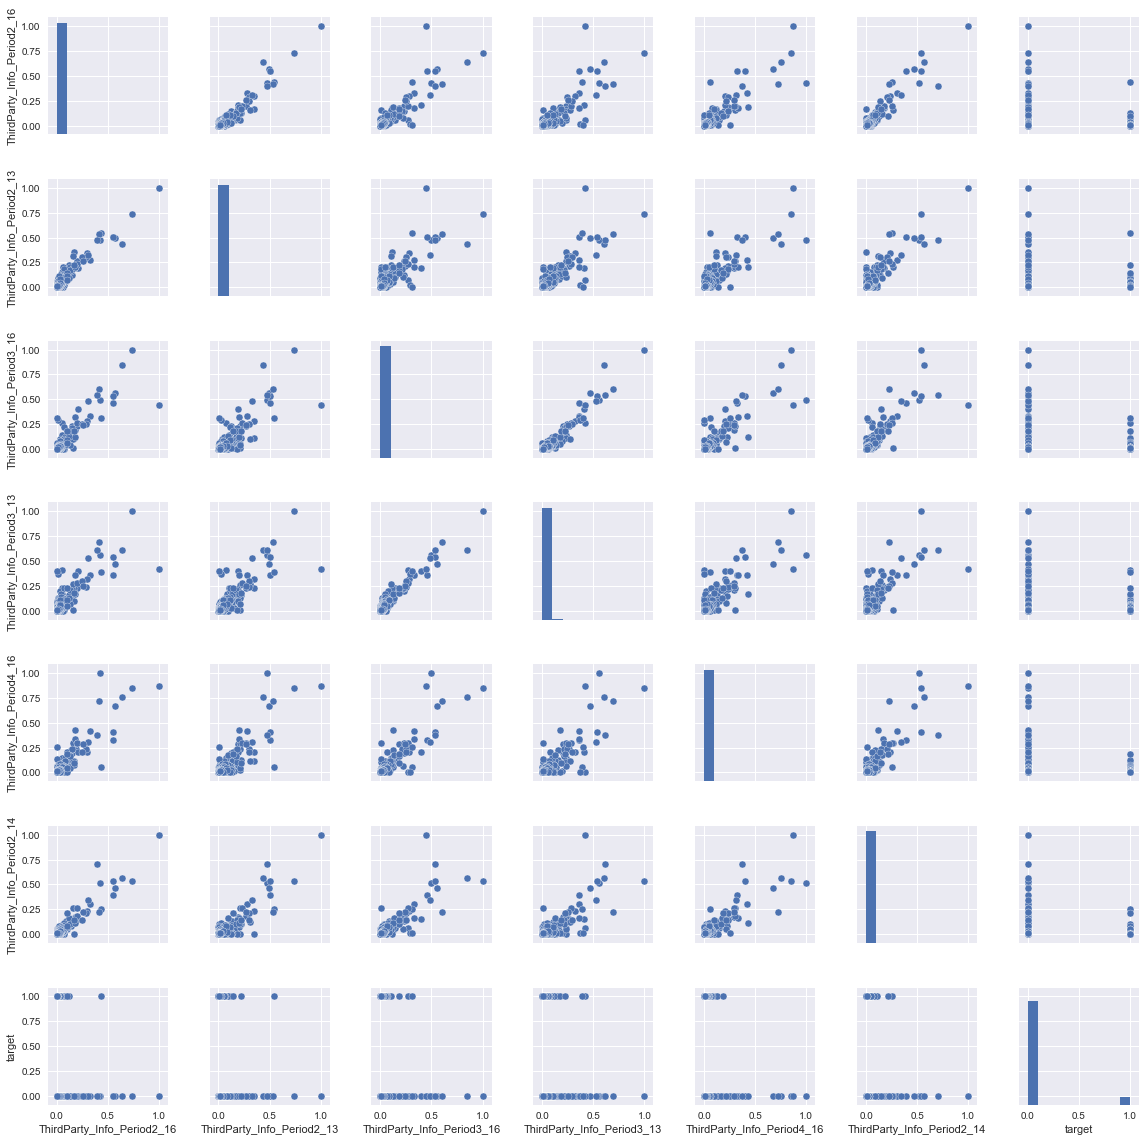

In [44]:
#查看数据类型主要属性的pairplot
sns.set()
cols=lnum_sort.iloc[:,:6].columns.tolist()+['target']
sns.pairplot(data_all[cols], size = 2.3)


In [45]:
#上图有较多的共线性特征，将共线性的特征进行删除，相关系数大于0.6
data_corr=data.corr()
cl=[]                                #用于存储需要扔掉的共线性特征
for i in range(data_corr.shape[0]-1):
    for j in range(i):
        item=data_corr.iloc[i+1:i+2,j:j+1]
        a=abs(item.values)
        if a>=0.6:
            cl=cl+item.columns.tolist()
cl=list(set(cl))                    #去除重复元素
            

In [48]:
#将共线性特征删除
data.drop(cl,axis=1,inplace=True)

In [51]:
#定义用于性能检验的函数
# def mae(y,ypred):
#     a=np.mean(abs(y-ypred))
#     return a 
def model_mae(model):
    model.fit(trainx.values,trainy.values)
    train_pred=model.predict(trainx.values)
    test_pred=model.predict(testx.values)
    tr= train_pred==trainy
    tr=tr.astype(int)
    train=tr.mean()
    ts= test_pred==testy
    ts=ts.astype(int)
    test=ts.mean()
    return train,test

In [78]:
#进行欠采样
dy=data_all[data_all['target']==1]
dn=data_all[data_all['target']!=1]
dn=dn.iloc[:dy.shape[0],:]
dyn=pd.concat([dn,dy],axis=0)
dyn_target=dyn['target'].values
dyn1=dyn.drop('target',axis=1)

In [91]:
from sklearn.cross_validation import train_test_split
trainx,testx,trainy,testy=train_test_split(dyn1.values,dyn_target,test_size=0.3)

In [94]:
from xgboost.sklearn import XGBClassifier 
from sklearn.metrics import precision_score,roc_auc_score

xgbc=XGBClassifier()
xgbc.fit(trainx,trainy)
testpre = xgbc.predict(testx)

auc_score = roc_auc_score(testy,testpre)
pre_score = precision_score(testy,testpre)

print("xgb_auc_score:",auc_score)
print("xgb_pre_score:",pre_score)



xgb_auc_score: 0.9157124447717232
xgb_pre_score: 0.9609120521172638


D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
